In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [2]:
train = pd.DataFrame()
train = pd.read_csv('../input/quora-question-pairs/train.csv.zip')

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test = pd.read_csv('../input/quora-question-pairs/test.csv.zip')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [7]:
train.shape

(404290, 6)

In [8]:
test.shape

(3563475, 3)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:xlabel='is_duplicate'>

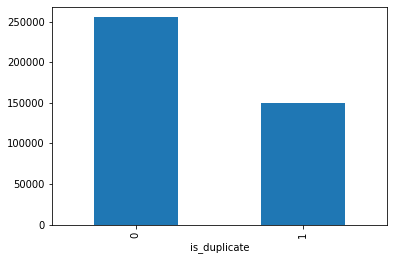

In [10]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [11]:
print("total number of questions for training are:- {}".format(len(train)))

total number of questions for training are:- 404290


In [12]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(round(len(train[train['is_duplicate']==0])/len(train) * 100),2))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(len(train[train['is_duplicate']==1])/len(train) * 100),2))

~> Question pairs are not Similar (is_duplicate = 0):
   63%

~> Question pairs are Similar (is_duplicate = 1):
   37%


In [13]:
#store all the question ids in a list 'qids'
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())

#get the unique qids by using np.unique on qids
unique_qs = len(np.unique(qids))

#get the sum of those qids which repeat more than one
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



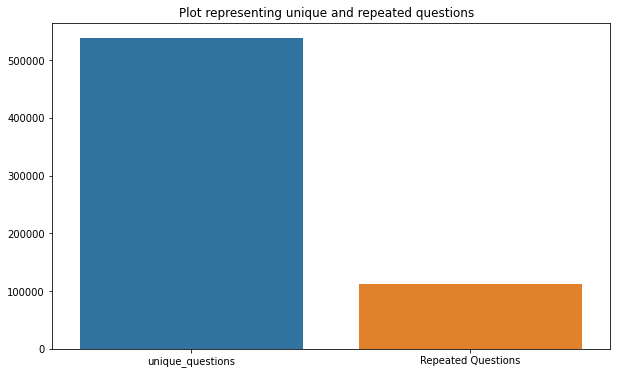

In [14]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [15]:
#checking for duplicate pairs by grouping on qid1 and qid2.
duplicate_pairs = train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("total number of duplicate questions: {}".format(duplicate_pairs.shape[0] - train.shape[0])) 

total number of duplicate questions: 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 157



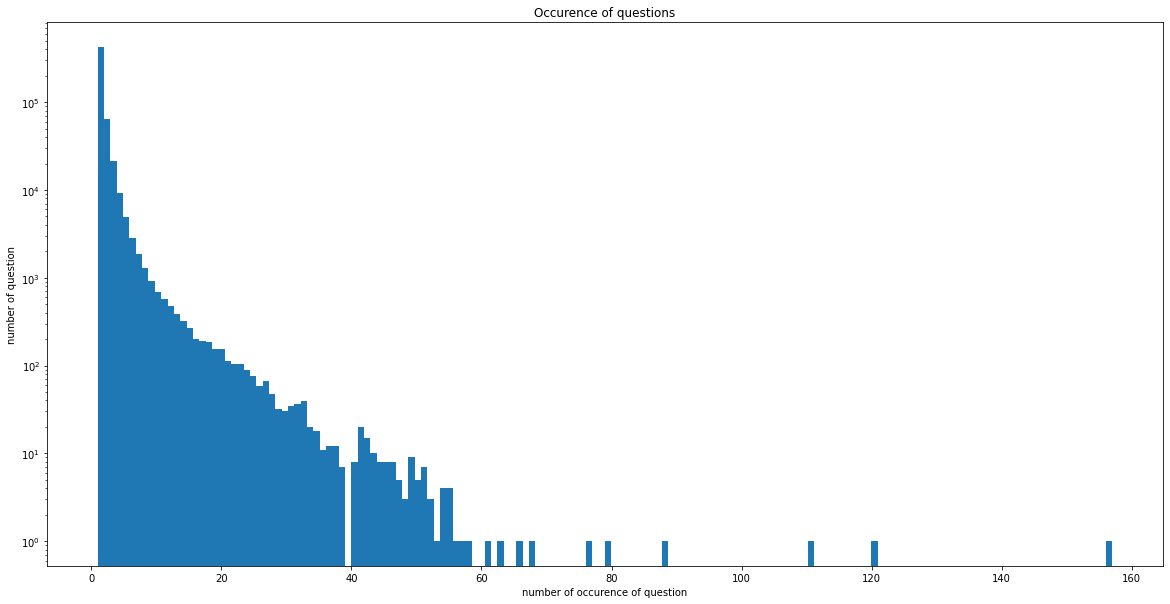

In [16]:
#plot occurences of questions
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)

plt.yscale('log', nonposy='clip')

plt.title("Occurence of questions")
plt.xlabel("number of occurence of question")
plt.ylabel("number of question")

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [17]:
#check for null values in an entire dataframe
null_rows = train[train.isnull().any(axis = 1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [18]:
#fill the nan values with a space
train = train.fillna(" ")
null_rows = train[train.isnull().any(axis = 1)]
print(null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic Feature Extraction before cleaning**
* **freq_qid1** = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [19]:
train['freq_qid1'] = train.groupby('qid1')['qid1'].transform('count') 
train['freq_qid2'] = train.groupby('qid2')['qid2'].transform('count')

train['q1len'] = train['question1'].astype(str).str.len()
train['q2len'] = train['question2'].astype(str).str.len()

train['q1_n_words'] = train['question1'].astype(str).apply(lambda row : len(row.split(" ")))
train['q2_n_words'] = train['question2'].astype(str).apply(lambda row : len(row.split(" ")))

In [20]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [21]:
train.values

array([[0, 1, 2, ..., 57, 14, 12],
       [1, 3, 4, ..., 88, 8, 13],
       [2, 5, 6, ..., 59, 14, 10],
       ...,
       [404287, 537928, 537929, ..., 17, 4, 3],
       [404288, 537930, 537931, ..., 127, 17, 25],
       [404289, 537932, 537933, ..., 45, 8, 10]], dtype=object)

In [22]:
train['word_Overlap'] = [set(x[3].split()) & set(x[4].split()) for x in train.values]
train['word_Common'] = train['word_Overlap'].str.len()
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{by, is, invest, the, What, guide, share, in, ...",10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{What, Kohinoor, (Koh-i-Noor), the}",4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{How, speed, can}",3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{in, Which}",2


In [23]:
train['word_Total'] = train['question1'].str.split().map(len) + train['question2'].str.split().map(len)

In [24]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{by, is, invest, the, What, guide, share, in, ...",10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{What, Kohinoor, (Koh-i-Noor), the}",4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{How, speed, can}",3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{in, Which}",2,20


In [25]:
train.drop('word_Overlap' , axis = 1, inplace = True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [26]:
train['word_share'] = train['word_Common'] / train['word_Total'] 

In [27]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


In [28]:
train['freq_q1+q2'] = train['freq_qid1'] + train['freq_qid2']
train['freq_q1-q2'] = abs(train['freq_qid1'] - train['freq_qid2'])

In [29]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [30]:
#Analysis of extracted features
print ("Minimum length of the questions in question1 : " , min(train['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(train['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [31]:
print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



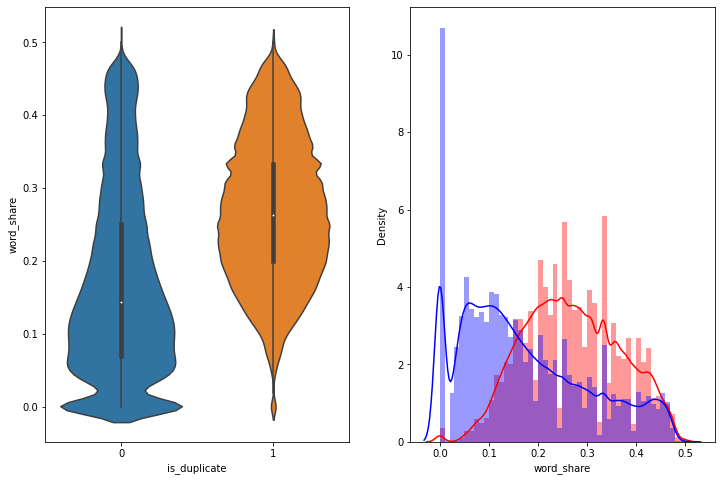

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



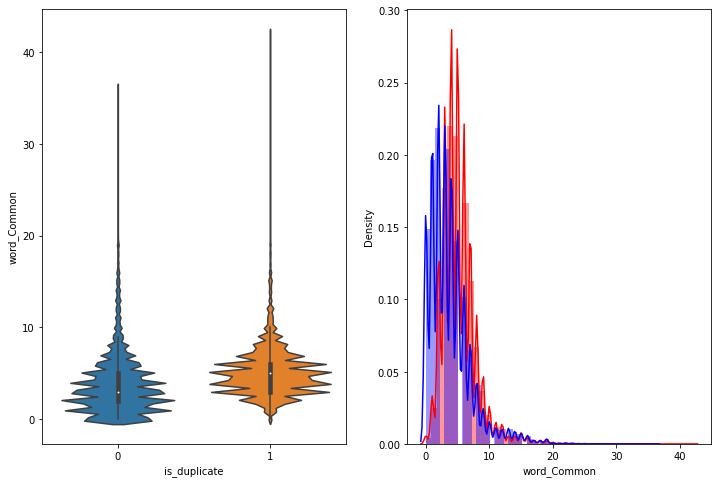

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [34]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3


## Preprocessing of Text
* Removing HTML tags
* Remove punctuation
* Stemming
* Removing stop words
* Expanding contractions

In [35]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

In [36]:
SAFE_DIV = 0.0001

In [37]:
!pip install --user distance

     |████████████████████████████████| 180 kB 925 kB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=94463f9f755b6364409721e96f9aa88d66632ff31ba3a54ee27fcf834c13cd81
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [38]:
def get_token_features(q1, q2):
    
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_min
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_max
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_min
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_max
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_min
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_max
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])  #last_word_eq
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])    #first_word_eq
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))  #abs_len_diff
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2   #mean_len
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [39]:
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [40]:
train = extract_features(train)
train.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [41]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# Analysis of Extracted Features

In [42]:
train_duplicate = train[train['is_duplicate'] == 1]
train_nonduplicate = train[train['is_duplicate'] == 0]

In [43]:
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([train_duplicate["question1"], train_duplicate["question2"]]).flatten()
n = np.dstack([train_nonduplicate["question1"], train_nonduplicate["question2"]]).flatten()

In [44]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [45]:
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [46]:
# reading the text files and removing the Stop Words:
#d = path.dirname('.')

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


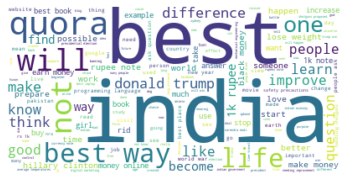

In [47]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


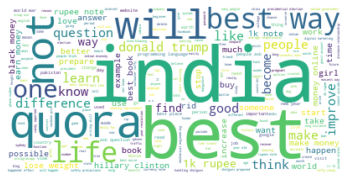

In [48]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

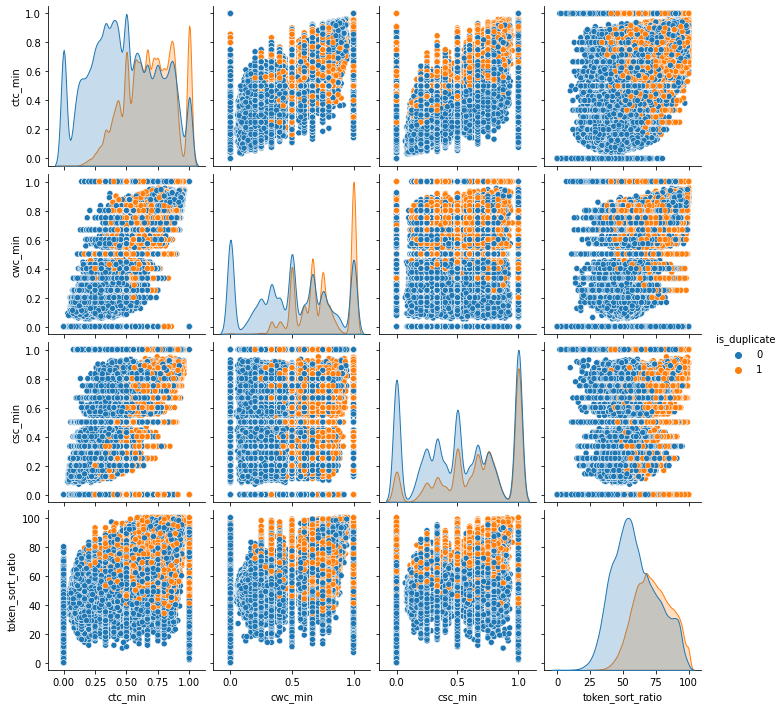

In [49]:
n = train.shape[0]
sns.pairplot(train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [50]:
train.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



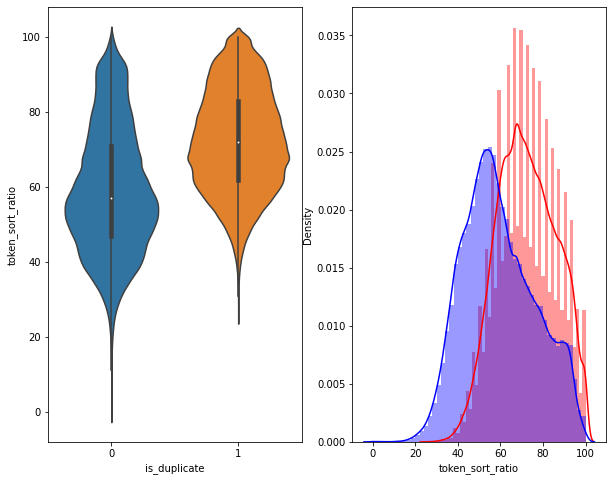

In [51]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



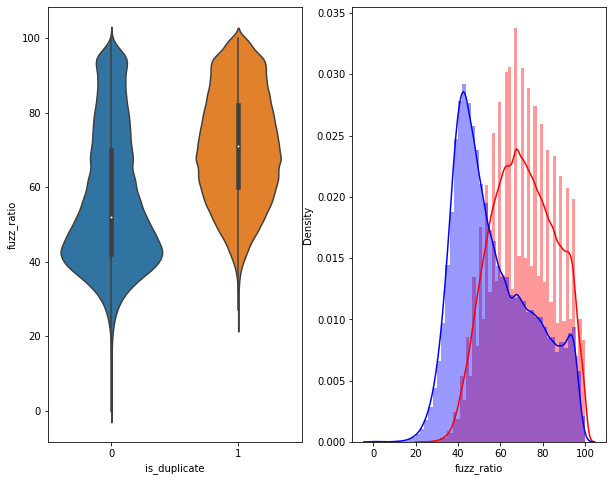

In [52]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [53]:
train.shape

(404290, 32)

In [54]:
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [55]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [56]:
questions = train['question1'] + train['question2']

In [57]:
i = 0
list_of_sentence = []
for sentence in questions:
    list_of_sentence.append(sentence)

In [58]:
import nltk

In [59]:
list_of_sentence = [nltk.word_tokenize(sent) for sent in list_of_sentence]

In [60]:
import gensim
#from gensim.models import Word2Vec
w2vmodel = gensim.models.Word2Vec(list_of_sentence,min_count = 5, vector_size = 50, workers = 4)


In [61]:
print(w2vmodel.wv.most_similar('sun'))

[('moon', 0.8485398292541504), ('jupiter', 0.81526118516922), ('orbit', 0.8021626472473145), ('atmosphere', 0.7807015180587769), ('light', 0.7651090621948242), ('pluto', 0.7415656447410583), ('earth', 0.7376753091812134), ('upwards', 0.7276656627655029), ('rotation', 0.7192918658256531), ('equator', 0.7086687684059143)]


In [62]:
print(w2vmodel.wv.most_similar('best'))

[('easiest', 0.7495132684707642), ('safest', 0.7116259336471558), ('cheapest', 0.6925053596496582), ('fastest', 0.6916694045066833), ('good', 0.6233890056610107), ('hardest', 0.6093577742576599), ('worst', 0.6070387959480286), ('recommended', 0.5985775589942932), ('healthiest', 0.57343989610672), ('coolest', 0.5620862245559692)]


In [63]:
w2v_words = list(w2vmodel.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  30433
sample words  ['the', 'what', 'is', 'i', 'how', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', 'you', 'why', 'it', 'my', 'best', 'on', 'does', 'have', 'or', 'which', 'be', 'if', 'not', 'some', 'that', 'with', 'should', 'get', 'an', 'from', 'your', 'india', 'own', 'will', 'people', 'when', 'who', 'like', 'at', 'good', 'would', 'there', 'as', 'about', 'between', 'one']


In [64]:
i = 0
list_of_sentences = []
for sentence in questions:
    list_of_sentences.append(sentence)

In [65]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)
tf_idf_vect.fit(list_of_sentences)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(list_of_sentences)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '000', '00am', '00k', '01', '02', '03', '04', '05', '06']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (404290, 18881)
the number of unique words including both unigrams and bigrams  18881


In [66]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [67]:
dictionary['step']

7.622031634521803

In [79]:
q1_feat = [nltk.word_tokenize(sent) for sent in train['question1']]
q2_feat = [nltk.word_tokenize(sent) for sent in train['question2']]

In [81]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q1_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q1.append(sent_vec)
    row += 1

100%|██████████| 404290/404290 [26:02<00:00, 258.82it/s]


In [82]:
tfidf_sent_vectors_q1[0:2]

[array([ 0.55091199, -1.21513289,  1.42474992, -0.80545131,  0.84886726,
         0.53844864,  0.14860144,  1.09238777, -1.25155004,  0.19667289,
        -1.2535712 ,  0.03765205, -0.69983358,  0.65103533, -1.01125716,
        -0.84422466, -0.7409028 , -0.57150515,  0.24590608,  0.72662773,
         0.82520628, -1.50619019, -0.16660701,  1.12727671, -0.69540459,
        -0.45304607, -0.24754674,  0.54687293, -1.02231821, -1.16659492,
         1.27385534, -0.88931812,  0.79120668, -0.30672752,  0.60428393,
         0.96812518,  0.75447209,  0.30358823,  0.3375217 ,  0.73490293,
        -0.8388226 , -0.20420067,  1.23443889, -0.19281469, -1.37907071,
         0.56560119,  0.47273842,  1.3862582 ,  0.84929533, -0.05246361]),
 array([-0.14566105, -0.06448558, -0.04617299,  0.29219369, -0.25396746,
        -0.86149908,  0.13194031,  0.54448151,  0.10305627, -0.3855183 ,
        -0.30631107, -0.1153305 ,  0.20150851, -0.03507256, -0.22704935,
        -0.40359659,  0.4387182 , -0.08983971,  0

In [84]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q2_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q2.append(sent_vec)
    row += 1

100%|██████████| 404290/404290 [25:51<00:00, 260.55it/s]


In [85]:
tfidf_sent_vectors_q2[0:2]

[array([ 0.52194043, -1.41332128,  1.55295052, -0.90007972,  0.97982773,
         0.8364791 ,  0.31262601,  1.02032717, -1.37520981,  0.25620688,
        -1.35166086, -0.16606131, -0.79723526,  0.52952567, -1.3610411 ,
        -0.93175873, -0.86959305, -0.79530198,  0.35036431,  0.81622225,
         0.94745928, -1.43055468, -0.16732075,  1.09765713, -1.01000308,
        -0.40698367, -0.18567926,  0.53398006, -1.02834794, -1.39554411,
         1.33730579, -1.11129863,  0.71656838, -0.36218894,  0.7423994 ,
         1.26509848,  0.74242163,  0.17612744,  0.41604468,  0.99068352,
        -0.76249458, -0.44488575,  1.29690014, -0.24267917, -1.33047907,
         0.73966252,  0.59357804,  1.60844213,  0.91038228, -0.07731031]),
 array([ 0.17326678, -1.03584948,  0.63753014, -0.41608037, -0.13374919,
        -0.4620885 , -0.0284489 ,  0.86386736, -0.72027604,  0.30861735,
        -0.00424775,  0.64548121, -0.07573344,  0.27093227,  0.10891541,
        -0.04297206,  0.43226725,  0.03808525, -0

In [86]:
df = pd.DataFrame()
df['q1_feat'] = list(tfidf_sent_vectors_q1)

In [87]:
df.head()

,q1_feat
0,"[0.5509119927544772, -1.2151328861936417, 1.42..."
1,"[-0.14566105183149247, -0.06448557783679341, -..."
2,"[0.7949325658678879, 0.21813525971223904, 1.66..."
3,"[0.5162488871406001, 0.4404579128136239, 0.512..."
4,"[0.531625125490678, 0.9197033923137331, 0.7175..."


In [88]:
df['q2_feat'] = tfidf_sent_vectors_q2
df.head()

,q1_feat,q2_feat
0,"[0.5509119927544772, -1.2151328861936417, 1.42...","[0.5219404307208467, -1.4133212806836886, 1.55..."
1,"[-0.14566105183149247, -0.06448557783679341, -...","[0.1732667770136911, -1.0358494838819314, 0.63..."
2,"[0.7949325658678879, 0.21813525971223904, 1.66...","[0.20761583320425608, -0.6095063069105401, 1.4..."
3,"[0.5162488871406001, 0.4404579128136239, 0.512...","[-0.028801177280704818, 0.10397783213399002, -..."
4,"[0.531625125490678, 0.9197033923137331, 0.7175...","[0.7192343939747317, 0.8551032052473221, 1.820..."


In [91]:
df3_q1 = pd.DataFrame(df.q1_feat.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feat.values.tolist(), index= df.index)

In [94]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.550912,-1.215133,1.424750,-0.805451,0.848867,0.538449,0.148601,1.092388,-1.251550,0.196673,...,-0.838823,-0.204201,1.234439,-0.192815,-1.379071,0.565601,0.472738,1.386258,0.849295,-0.052464
1,-0.145661,-0.064486,-0.046173,0.292194,-0.253967,-0.861499,0.131940,0.544482,0.103056,-0.385518,...,-0.063594,-0.067927,0.378717,0.023204,0.030641,-0.379087,-0.630825,0.284822,0.496848,0.427359
2,0.794933,0.218135,1.669601,0.044822,1.327946,0.368178,-0.085482,1.130747,-0.189757,0.008874,...,-0.904100,0.438383,-0.978542,-0.145097,0.788275,0.751456,0.832245,0.379740,0.089628,-0.204702
3,0.516249,0.440458,0.512788,-1.217100,-0.613436,0.955083,-0.435670,-0.830313,-0.479838,0.247488,...,-0.238673,0.342286,0.680849,-0.294064,0.312910,-1.092596,0.254735,-1.641936,-0.212651,-1.321483
4,0.531625,0.919703,0.717535,-0.290030,-0.145957,-0.465504,0.347863,0.213522,-1.512634,-1.467447,...,-0.002094,0.867029,-0.787380,-0.174598,-0.001393,-0.936098,-0.140074,0.129209,0.437218,-0.219810


In [95]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [96]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.521940,-1.413321,1.552951,-0.900080,0.979828,0.836479,0.312626,1.020327,-1.375210,0.256207,...,-0.762495,-0.444886,1.296900,-0.242679,-1.330479,0.739663,0.593578,1.608442,0.910382,-0.077310
1,0.173267,-1.035849,0.637530,-0.416080,-0.133749,-0.462088,-0.028449,0.863867,-0.720276,0.308617,...,-0.015466,0.002052,0.463141,0.659968,-1.276973,-0.279821,0.112813,0.544736,0.932015,-0.233331
2,0.207616,-0.609506,1.444948,0.113375,1.415666,0.714632,-0.298154,1.076266,-0.372037,-0.250741,...,-0.810254,0.550776,-0.349944,-0.276837,-0.040867,0.370440,1.235562,0.355806,0.486124,-0.003668
3,-0.028801,0.103978,-0.451306,-1.234523,-0.570139,-0.477695,-0.972635,0.977668,-2.115678,-0.836023,...,-2.465381,0.099617,1.109308,-0.585759,1.072484,-1.128379,0.360046,0.481059,0.030319,0.581623
4,0.719234,0.855103,1.820770,-0.502915,-0.401433,-0.561409,0.029302,0.233557,-1.861551,-1.251954,...,0.082380,2.060582,-0.145238,-0.163716,-0.982137,-2.006751,-0.013360,-0.048300,0.865493,-0.798924


In [97]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [98]:
train.drop(['qid1', 'qid2', 'question1', 'question2'],inplace = True, axis = 1)
#train.head

<bound method NDFrame.head of             id  is_duplicate  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  \
0            0             0          1          1     66     57          14   
1            1             0          4          1     51     88           8   
2            2             0          1          1     73     59          14   
3            3             0          1          1     50     65          11   
4            4             0          3          1     76     39          13   
...        ...           ...        ...        ...    ...    ...         ...   
404285  404285             0          2          2     85     79          14   
404286  404286             1         12          1     41     42           8   
404287  404287             0          1          1     17     17           4   
404288  404288             0          1          1     94    127          17   
404289  404289             0          1          1     37     45           8   

        q

In [99]:
train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,1,66,57,14,12,10,26,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,4,1,51,88,8,13,4,21,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,1,1,73,59,14,10,3,24,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,1,1,50,65,11,9,0,20,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,3,1,76,39,13,7,2,20,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [100]:
df3_q1['id']= train['id']
df3_q2['id']= train['id']
train  = train.merge(df3_q1, on='id',how='left')
train = train.merge(df3_q2, on='id',how='left')
#result  = df1.merge(df2, on='id',how='left')
train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,0,1,1,66,57,14,12,10,26,...,-0.762495,-0.444886,1.296900,-0.242679,-1.330479,0.739663,0.593578,1.608442,0.910382,-0.077310
1,1,0,4,1,51,88,8,13,4,21,...,-0.015466,0.002052,0.463141,0.659968,-1.276973,-0.279821,0.112813,0.544736,0.932015,-0.233331
2,2,0,1,1,73,59,14,10,3,24,...,-0.810254,0.550776,-0.349944,-0.276837,-0.040867,0.370440,1.235562,0.355806,0.486124,-0.003668
3,3,0,1,1,50,65,11,9,0,20,...,-2.465381,0.099617,1.109308,-0.585759,1.072484,-1.128379,0.360046,0.481059,0.030319,0.581623
4,4,0,3,1,76,39,13,7,2,20,...,0.082380,2.060582,-0.145238,-0.163716,-0.982137,-2.006751,-0.013360,-0.048300,0.865493,-0.798924


In [101]:
train.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,0,1,1,66,57,14,12,10,26,...,-0.762495,-0.444886,1.296900,-0.242679,-1.330479,0.739663,0.593578,1.608442,0.910382,-0.077310
1,1,0,4,1,51,88,8,13,4,21,...,-0.015466,0.002052,0.463141,0.659968,-1.276973,-0.279821,0.112813,0.544736,0.932015,-0.233331
2,2,0,1,1,73,59,14,10,3,24,...,-0.810254,0.550776,-0.349944,-0.276837,-0.040867,0.370440,1.235562,0.355806,0.486124,-0.003668
3,3,0,1,1,50,65,11,9,0,20,...,-2.465381,0.099617,1.109308,-0.585759,1.072484,-1.128379,0.360046,0.481059,0.030319,0.581623
4,4,0,3,1,76,39,13,7,2,20,...,0.082380,2.060582,-0.145238,-0.163716,-0.982137,-2.006751,-0.013360,-0.048300,0.865493,-0.798924


In [102]:
train.drop('is_duplicate', inplace= True, axis = 1)

In [111]:
train_new = pd.DataFrame()
train_new = pd.read_csv('../input/quora-question-pairs/train.csv.zip')

In [112]:
y = train_new['is_duplicate']

In [114]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
